In [1]:
import os
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, label, find_objects

from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
from skimage.exposure import adjust_gamma
import imageio
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

In [3]:
def cluster_optical_flow(us, vs, kernel_type='gaussian', kernel_size=21, normalize=False, verbose=False):    
    # create a gaussian kernel of size NxN
    N = kernel_size
    if kernel_type == 'gaussian':
        gaussian_window = sp.signal.windows.gaussian(N, std=5, sym=True)
        gaussian_window = gaussian_window.reshape(-1, 1)

        gaussian_kernel = gaussian_window @ gaussian_window.T
        gaussian_kernel[N // 2, N // 2] = 0  # Set the center value to 0
        kernel_gpu = cp.asarray(gaussian_kernel)  # Convert to CuPy array for GPU usage

    elif kernel_type == 'uniform':
        kernel_gpu = cp.ones((N, N), dtype=cp.float32)
        kernel_gpu[N // 2, N // 2] = 0
        kernel_gpu = kernel_gpu / cp.sum(kernel_gpu)

    # Convolve horizontal optical flow with the kernel
    cluster = []

    for u, v in tqdm(zip(us, vs), disable=(not verbose)):
        u_gpu = cp.asarray(u)
        v_gpu = cp.asarray(v)

        if normalize:
            norm = cp.sqrt(u_gpu**2 + v_gpu**2)
            norm[norm == 0] = 1.0  # Avoid division by zero
            u_gpu = u_gpu / norm
            v_gpu = v_gpu / norm
            u_gpu[cp.isnan(u_gpu)] = 0
            v_gpu[cp.isnan(v_gpu)] = 0

        # Perform convolution using CuPy's GPU-based convolution
        u_gpu = u_gpu * cpx_ndimage.convolve(u_gpu, kernel_gpu, mode='constant', cval=0.0)
        v_gpu = v_gpu * cpx_ndimage.convolve(v_gpu, kernel_gpu, mode='constant', cval=0.0)

        # Append the sum of the convolved u and v to the cluster
        cluster.append(u_gpu.get() + v_gpu.get())  # Move the result back to CPU memory

    return cluster

In [4]:
def remove_static_tracks(df, movement_threshold=1.0):
    """
    Removes static tracks based on the total displacement of particles.
    
    Parameters:
    - df: pandas DataFrame, contains the particle tracking data with 'x', 'y', and 'particle' columns
    - movement_threshold: float, the minimum total displacement required for a track to be considered valid
    
    Returns:
    - filtered DataFrame containing only the tracks with total displacement greater than the movement threshold
    """
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        # Get the x and y positions and compute the differences
        x_diff = track['x'].diff().dropna()
        y_diff = track['y'].diff().dropna()

        # Calculate the Euclidean distance (displacement) between consecutive points
        displacement = np.sqrt(x_diff**2 + y_diff**2)

        # Calculate the total displacement for this track
        total_displacement = displacement.sum()

        # If the total displacement is greater than the movement threshold, keep the track
        if total_displacement > movement_threshold:
            valid_particles.append(particle_id)

    # Filter the DataFrame to keep only valid particles
    return df[df['particle'].isin(valid_particles)]


# Combine the previous 2 functions to remove discontinuous and static tracks
def filter_tracks(df, movement_threshold=1.0):
    # Drop NaNs from the dataframe before processing
    df = df.dropna(subset=['x', 'y', 'frame'])
    
    # df_no_gaps = remove_discontinuous_tracks(df)  # Remove tracks with gaps
    df_filtered = remove_static_tracks(df, movement_threshold)  # Remove static tracks
    
    return df_filtered

In [28]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min');
file_name = 'div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tiff'
resolution = 2.7778   #px./um
frame_interval = 2.00137  #s/frame.

image_path = data_folder+'\\'+file_name
img = tiff.imread(image_path) 
img_mean = tiff.imread(data_folder+'\\AVG_div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tif')
raw_im = tiff.imread(data_folder+'\\div2cortex_C1_timelapse1_2secPerTP_5min_jitter_corrected.tiff')

of_path = data_folder+'\\Op_flow'
of_list = natsorted(os.listdir(of_path))
# mask = sio.loadmat(data_folder +'\\cell_mask.mat')['binary_mask']   # if want to use the raw cell mask
mask = sio.loadmat(data_folder +'\\neural_mask.mat')['neural_mask']

mask = mask.astype(float)  # Convert the mask to float
mask[mask==0]=np.NaN

n_frames = (len(of_list))  # number of time-frames in the movie
# y_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[0]
# x_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[1]
y_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[0]
x_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[1]

vy_all = np.zeros((n_frames, y_span, x_span))

vx_all = np.zeros((n_frames, y_span, x_span))

for i in tqdm(range(len(of_list))):
    # matr = np.load(of_path+'\\'+of_list[i])
    matr = sio.loadmat(of_path+'\\'+of_list[i])
    vy_all[i,:,:] = matr['vy']
    vx_all[i,:,:] = matr['vx']

cluster = cluster_optical_flow(vx_all, vy_all, kernel_type='gaussian', kernel_size=11, normalize=False, verbose=False)  
# kernel_size was 11 earlier

100%|██████████| 150/150 [00:00<00:00, 281.19it/s]


In [6]:
# Parameters for particle detection
diameter = 5  # Approximate size of the particle in pixels
minmass = 1.0  # Minimum integrated brightness (mass) of a particle to be considered (we get an idea from the previous cell)
search_range = 5  # Maximum displacement between frames in pixels

# A list to store particle locations for each frame
particle_positions = []

# Loop through each 2D frame to detect particles
for t in tqdm(range(n_frames)):
    frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Get the 2D frame from the 3D stack (apply mask if needed)
    # Detect particles with sub-pixel accuracy in this frame
    particles = tp.locate(frame, diameter=diameter, minmass=minmass, separation=15)
    
    # Add the frame number to each detected particle's data
    particles['frame'] = t
    
    # Store the detected particles
    particle_positions.append(particles)

# Combine all particle positions across frames into a single DataFrame
peaks_df = pd.concat(particle_positions)

# Use trackpy to link the particles over time
tp_trajectories = tp.link(peaks_df, search_range=search_range, memory=1)

# Now tp_trajectories contains sub-pixel accurate positions and is linked over time
# print(tp_trajectories.head())

Frame 149: 59 trajectories present.


In [7]:
# Filter out tracks with less than 8 frames
tp_trajectories_pruned = tp.filter_stubs(tp_trajectories, 8)  

movement_threshold = 1.0  # Adjust this threshold as needed
tp_trajectories_filtered = filter_tracks(tp_trajectories_pruned, movement_threshold)

# Calculate the duration of each track
track_duration = tp_trajectories_filtered.groupby('particle')['frame'].apply(lambda x: x.max() - x.min() + 1).reset_index(name='track_duration')
short_tracks = track_duration[track_duration['track_duration'] < 8]  # Filter tracks with less than 38 frames
print(short_tracks)   # Display tracks with less than10 frames


Empty DataFrame
Columns: [particle, track_duration]
Index: []


## Visualize cluster peaks

Frame 149: 5 trajectories present.
Number of unique particles in the selected region and timepoints: 20


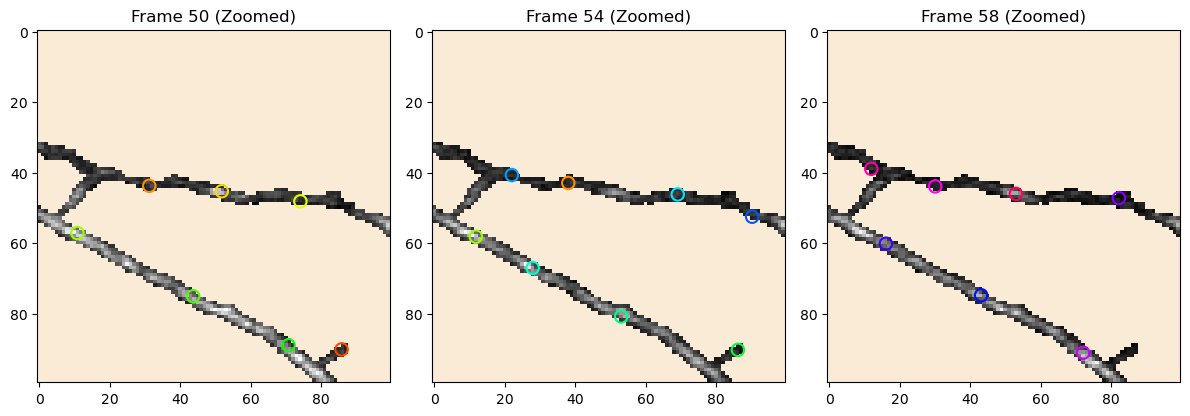

In [8]:
# Define the small region (adjust as needed)
x_min, x_max = 350, 450  # X range of the region
y_min, y_max = 220, 320  # Y range of the region

# Store particle positions
particle_positions = []

# Process frames within the small region
for t in tqdm(range(n_frames)):
    frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Extract 2D frame
    small_region = frame[y_min:y_max, x_min:x_max]  # Crop to small region
    
    # Detect particles in the small region
    particles = tp.locate(small_region, diameter=diameter, minmass=minmass, separation=15)
    
    # Adjust coordinates to match the original image
    particles['x'] += x_min
    particles['y'] += y_min
    particles['frame'] = t  # Add frame number
    
    particle_positions.append(particles)

# Combine detected particles across frames
peaks_df = pd.concat(particle_positions)

# Link particles over time
tp_trajectories = tp.link(peaks_df, search_range=search_range, memory=1)

shift_frame = 4;
frames_to_show = [50, 50+shift_frame, 50+2*shift_frame ]  # Frames to visualize

# Filter trajectories within the region and time range
filtered_particles = tp_trajectories[
    (tp_trajectories['x'].between(x_min, x_max)) &
    (tp_trajectories['y'].between(y_min, y_max)) &
    (tp_trajectories['frame'].isin(frames_to_show))
]

# Count unique particle IDs
num_particles_selected = filtered_particles['particle'].nunique()

print(f"Number of unique particles in the selected region and timepoints: {num_particles_selected}")
# Generate unique colors for each particle

# Use Seaborn color palette or any colormap
unique_particles = filtered_particles['particle'].unique()  # Get unique particle IDs
colors = sns.color_palette("hsv", len(unique_particles))  # Generate distinct colors

# Map each particle ID to a color
particle_colors = {particle: colors[i] for i, particle in enumerate(unique_particles)}


# Plot the zoomed-in tracking results for multiple frames
fig, axes = plt.subplots(1, 3, figsize=(12, 8))  # Adjusted size for better visibility
axes = axes.flatten()  # Flatten 2D array of axes to 1D


for ax, frame_idx in zip(axes, frames_to_show):
    frame = (img[frame_idx] * mask)
    zoomed_frame = frame[y_min:y_max, x_min:x_max]  # Crop to zoomed-in region
    ax.imshow(zoomed_frame, cmap='gray', origin='upper')
    ax.set_facecolor('antiquewhite')

    # Overlay tracked particle positions with unique colors
    frame_particles = tp_trajectories[tp_trajectories['frame'] == frame_idx]
    
    for _, particle in frame_particles.groupby('particle'):
        pid = particle['particle'].iloc[0]  # Get particle ID
        color = particle_colors[pid]  # Retrieve assigned color
        
        ax.scatter(particle['x'] - x_min, particle['y'] - y_min, 
                   s=80, color=color, facecolors='none', linewidth=1.5, 
                   label=f"Particle {pid}")

    ax.set_title(f"Frame {frame_idx} (Zoomed)")

plt.tight_layout()
plt.show()


## Visualize Tracks

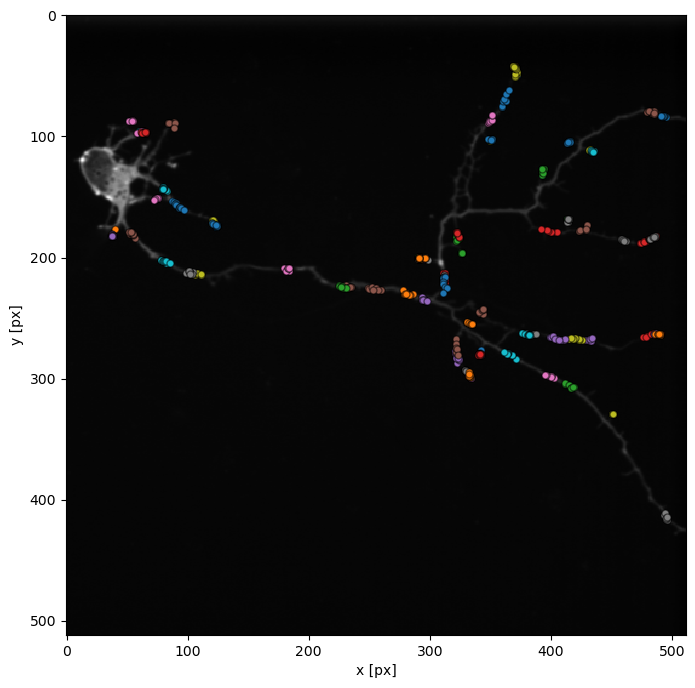

In [34]:
img = tiff.imread(data_folder+'\\'+file_name) 

img_mean = tiff.imread(data_folder+'\\AVG_div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tif')
from skimage.exposure import adjust_gamma
img_mean = adjust_gamma(img_mean, gamma=0.001)  # Increase gamma (>1 makes it darker)

# Visualize the trajectories
fig, ax = plt.subplots(figsize = (8,12))  # Create a figure and axes
tp.plot_traj(tp_trajectories_filtered,superimpose=img_mean,ax=ax)  # Pass the axes to the plot_traj function

# Modify line properties
import matplotlib.colors as mcolors  # Import color utilities

for line in ax.lines:
    line.set_linestyle('dashed')  # Dashed lines
    line.set_marker('o')  # Circular markers
    line.set_markersize(5)  # Marker size
    line.set_linewidth(1)  # Line width
    
    # Preserve original face color
    original_color = line.get_color()  # Get the trajectory color
    line.set_markerfacecolor(original_color)  # Keep face solid

    # Set edge color to transparent black
    transparent_black = (0, 0, 0, 0.5)  # Black with 50% transparency
    line.set_markeredgecolor(transparent_black)  # Apply transparent edges
    line.set_markeredgewidth(1)  # Edge thickness


# Show plot
plt.show()

ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\filtered_tracks_circles.svg', format='svg', bbox_inches='tight', dpi = 600)
fig.savefig(data_folder+'\\filtered_tracks_circles.png', format='png', bbox_inches='tight', dpi = 600)

### Save trajectories as a movie

100%|██████████| 151/151 [03:04<00:00,  1.22s/it]


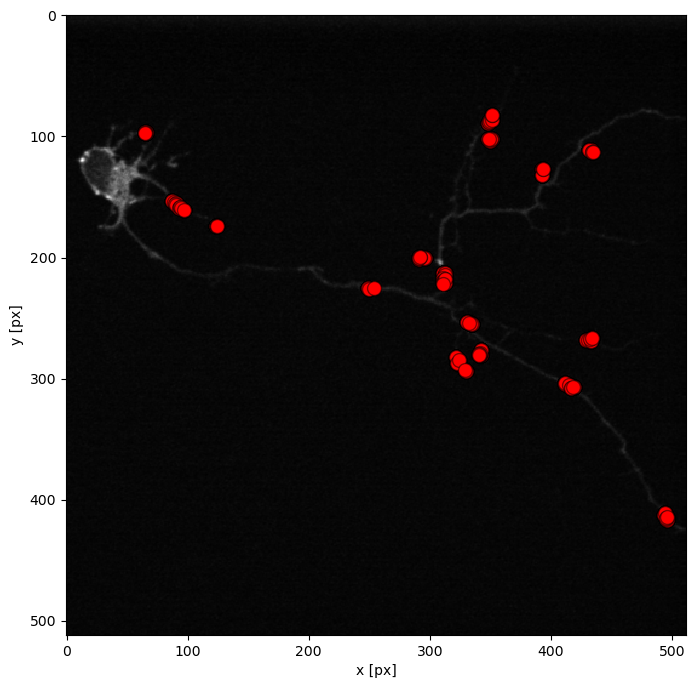

In [46]:
from tqdm import tqdm
from skimage.exposure import rescale_intensity

# Load the images
img = tiff.imread(data_folder+'\\'+file_name)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 12))

# Prepare the list for storing frames
frames = []

# Define the constant color for all tracks (red)
constant_color = 'r'  # Red color

# Ensure the loop iterates within bounds
num_frames = len(img)
for i in tqdm(range(num_frames)):
    # Increase the contrast of the current frame using rescale_intensity
    adjusted_img = rescale_intensity(raw_im[i], in_range='image', out_range=(0, 1))  # Increase contrast
    
    # Plot only the trajectory up to the current frame
    tp.plot_traj(tp_trajectories_filtered[:i+1], superimpose=adjusted_img, ax=ax)

    # Modify line properties for all lines
    for line in ax.lines:
        line.set_color(constant_color)  # Set the color to red for all tracks
        line.set_linestyle('dashed')
        line.set_marker('o')
        line.set_markersize(10)
        line.set_linewidth(1)
        
        original_color = line.get_color()
        line.set_markerfacecolor(original_color)
        
        transparent_black = (0, 0, 0, 0.5)
        line.set_markeredgecolor(transparent_black)
        line.set_markeredgewidth(1)

    ax.set_aspect('equal')
    
    # Capture the frame as an image
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

# Save the frames as a .gif at 25 fps
gif_path = data_folder+'\\filtered_tracks_circles.gif'
imageio.mimsave(gif_path, frames, duration=1/25)  # 25 fps


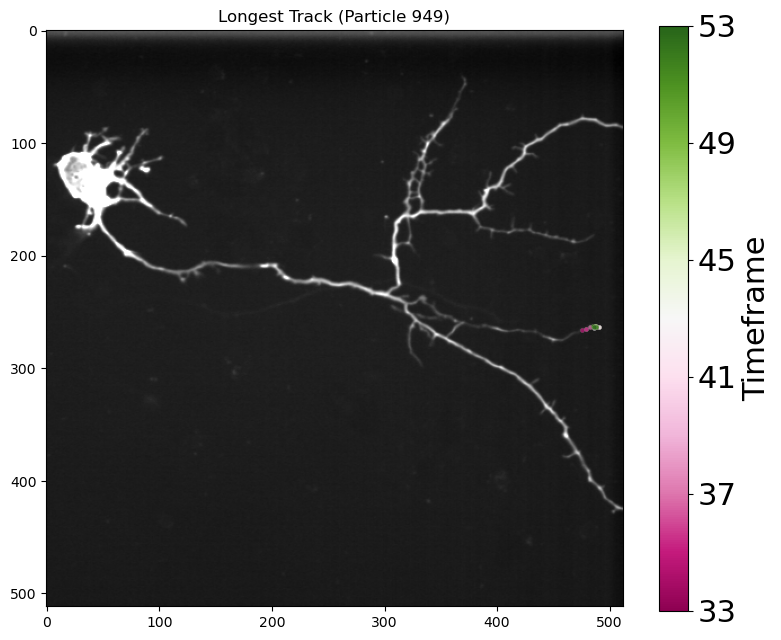

In [45]:
# Step 1: Identify the longest duration track (you already have this)
longest_track = metrics.groupby('particle')['track_length'].max().idxmax()  # ID of the longest track

# Step 2: Filter out only the longest track from the 'trajectories' dataframe
longest_track_data = trajectories[trajectories['particle'] == longest_track]

# Step 3: Extract x, y locations of the specific particle
x_locations = longest_track_data['x'].values  # x coordinates
y_locations = longest_track_data['y'].values  # y coordinates

# Step 4: Optional print to verify the coordinates
# print(f"X locations: {x_locations}")
# print(f"Y locations: {y_locations}")

# Step 5: Reset the index to avoid ambiguity between index and columns
longest_track_data = longest_track_data.reset_index(drop=True)

# Step 6: Create the plot with progressive colormap
fig, ax = plt.subplots(figsize=(8, 12))  # Create a figure and axes

# Generate a new colormap (use 'plasma' for better contrast against grayscale background)
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=longest_track_data['frame'].min(), vmax=longest_track_data['frame'].max())

x_min = int(np.floor(np.min(x_locations))); x_max = int(np.floor(np.max(x_locations)))
y_min = int(np.floor(np.min(y_locations))); y_max = int(np.floor(np.max(y_locations)))
               
# Show the image as background (zoomed-in region)
# img_zoom = img[0][y_min-20:y_max+20, x_min-40:x_max+40]  # Assuming zoomed region defined earlier
clahe = cv2.createCLAHE(clipLimit=0.05, tileGridSize=(4, 4))
img_contrast = clahe.apply(np.mean(raw_im,axis=0).astype(np.uint8))
ax.imshow(img_mean, cmap='gray', origin='upper')  # Display the image with some transparency

# Plot the track with scatter plot, where each point is colored according to its frame
for i, (frame, data) in enumerate(longest_track_data.groupby('frame')):
    color = cmap(norm(frame))  # Map frame to a color
    ax.scatter(data['x'], data['y'], color=color, s=10, label=f"Frame {frame}" if i == 0 else "", edgecolors='grey', linewidth=0.2, alpha=0.7)  # Increased size of points with black edges
    # ax.scatter(data['x'], data['y'], color='r', s=30, label=f"Frame {frame}" if i == 0 else "", edgecolors='black', linewidth=1, alpha=0.7)  # Increased size of points with black edges
    
import matplotlib.ticker as ticker

# Add a colorbar to show the time progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create the colorbar and modify ticks to show integers only
cbar = fig.colorbar(sm, ax=ax, label='Timeframe', shrink=0.5)

# Set the ticks to integers
cbar.set_ticks(np.arange(int(norm.vmin), int(norm.vmax)+1, 4))

# Format the ticks as integers
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# Set the font size for the tick labels and colorbar label
cbar.ax.tick_params(labelsize=22)  # Increase font size of ticks (e.g., 14)
cbar.set_label('Timeframe', fontsize=22)  # Increase font size of label (e.g., 16)



# Show plot with equal axis scaling
ax.set_aspect('equal')  # Set equal axis scaling
plt.title(f"Longest Track (Particle {longest_track})")
plt.tight_layout()
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\longest_track_CLAHE_v2.png', format='png', bbox_inches='tight', dpi=600)


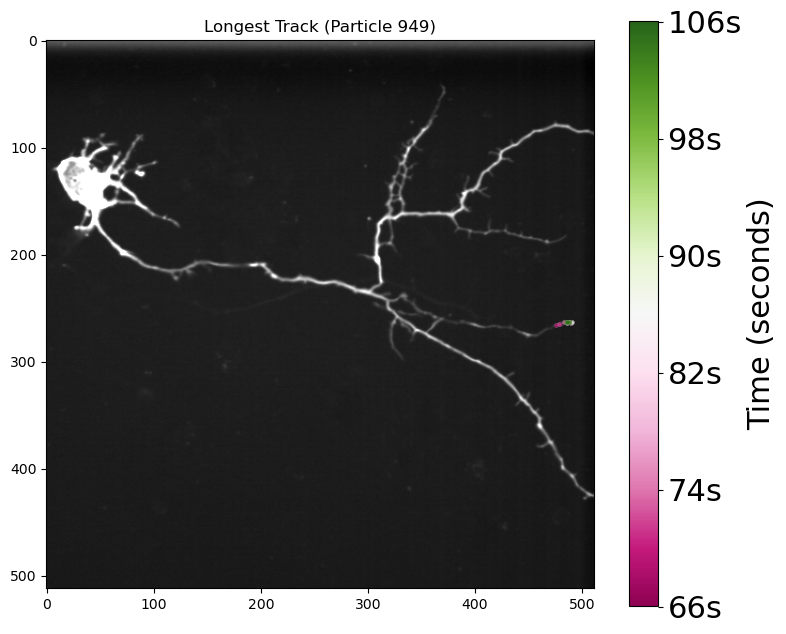

In [46]:
# Step 1: Identify the longest duration track (you already have this)
longest_track = metrics.groupby('particle')['track_length'].max().idxmax()  # ID of the longest track

# Step 2: Filter out only the longest track from the 'trajectories' dataframe
longest_track_data = trajectories[trajectories['particle'] == longest_track]

# Step 3: Extract x, y locations of the specific particle
x_locations = longest_track_data['x'].values  # x coordinates
y_locations = longest_track_data['y'].values  # y coordinates

# Step 4: Reset the index to avoid ambiguity between index and columns
longest_track_data = longest_track_data.reset_index(drop=True)

# Step 5: Create the plot with progressive colormap
fig, ax = plt.subplots(figsize=(8, 12))  # Create a figure and axes

# Generate a new colormap (use 'plasma' for better contrast against grayscale background)
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=longest_track_data['frame'].min(), vmax=longest_track_data['frame'].max())

x_min = int(np.floor(np.min(x_locations))); x_max = int(np.floor(np.max(x_locations)))
y_min = int(np.floor(np.min(y_locations))); y_max = int(np.floor(np.max(y_locations)))

# Show the image as background (zoomed-in region)
clahe = cv2.createCLAHE(clipLimit=0.05, tileGridSize=(4, 4))
img_contrast = clahe.apply(np.mean(raw_im, axis=0).astype(np.uint8))
ax.imshow(img_mean, cmap='gray', origin='upper')  # Display the image with some transparency

# Plot the track with scatter plot, where each point is colored according to its frame
for i, (frame, data) in enumerate(longest_track_data.groupby('frame')):
    color = cmap(norm(frame))  # Map frame to a color
    ax.scatter(data['x'], data['y'], color=color, s=10, label=f"Frame {frame}" if i == 0 else "", edgecolors='grey', linewidth=0.2, alpha=0.7)

import matplotlib.ticker as ticker

# Add a colorbar to show the time progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create the colorbar and modify ticks to show integers only
cbar = fig.colorbar(sm, ax=ax, label='Timeframe', shrink=0.5)

# Set the ticks to integers, adjusting the ticks to correspond to time in seconds
cbar.set_ticks(np.arange(int(norm.vmin), int(norm.vmax)+1, 4))

# Format the ticks as time in seconds (multiplying by 2)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x*2)}s'))

# Set the font size for the tick labels and colorbar label
cbar.ax.tick_params(labelsize=22)  # Increase font size of ticks (e.g., 14)
cbar.set_label('Time (seconds)', fontsize=22)  # Update label to reflect time in seconds

# Show plot with equal axis scaling
ax.set_aspect('equal')  # Set equal axis scaling
plt.title(f"Longest Track (Particle {longest_track})")
plt.tight_layout()
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\longest_track_CLAHE_v4.png', format='png', bbox_inches='tight', dpi=600)


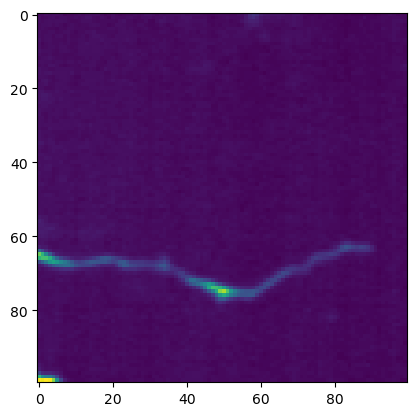

In [43]:
plt.imshow(img_mean[200:300,400:500])

In [219]:
np.arange(int(norm.vmin)-32, int(norm.vmax)+1-32, 4)

array([ 1,  5,  9, 13, 17, 21])

In [21]:
longest_track_data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
0,264.997972,479.042596,5.702821,1.277040,0.533876,0.890704,31.589084,0.000642,33,949,0.000000,0.000000,1.0,0.000000,0.000000
1,265.814312,475.851943,25.659682,1.294653,0.608840,4.036532,124.318158,0.000210,35,949,-3.190653,0.816341,2.0,3.293430,1.646715
2,265.251501,478.907939,16.636922,1.269281,0.538670,2.674782,83.449618,0.000302,36,949,3.055995,-0.562811,1.0,3.107389,3.107389
3,263.117122,482.975030,19.156492,1.283064,0.514358,2.904224,106.484981,0.000197,37,949,4.067091,-2.134379,1.0,4.593125,4.593125
4,263.315789,485.994152,11.759148,1.343166,0.663565,1.701982,61.143291,0.000387,38,949,3.019122,0.198667,1.0,3.025652,3.025652
5,263.597938,490.171134,11.603437,1.154105,0.480309,2.272838,46.024226,0.000726,39,949,4.176982,0.282149,1.0,4.186500,4.186500
6,263.111579,486.890526,8.431212,1.313092,0.640805,1.331244,43.746448,0.000643,41,949,-3.280608,-0.486359,2.0,3.316464,1.658232
7,263.819876,486.068323,1.193034,1.270790,0.800037,0.229715,4.484890,0.002763,43,949,-0.822203,0.708297,2.0,1.085220,0.542610
8,263.390625,490.617188,1.658288,1.071652,0.432441,0.388661,6.419623,0.004075,44,949,4.548865,-0.429251,1.0,4.569073,4.569073
9,262.872727,487.226263,9.722881,1.238278,0.519204,1.649943,47.451846,0.000524,45,949,-3.390925,-0.517898,1.0,3.430246,3.430246


## Plotting intensity vs time for the longest track

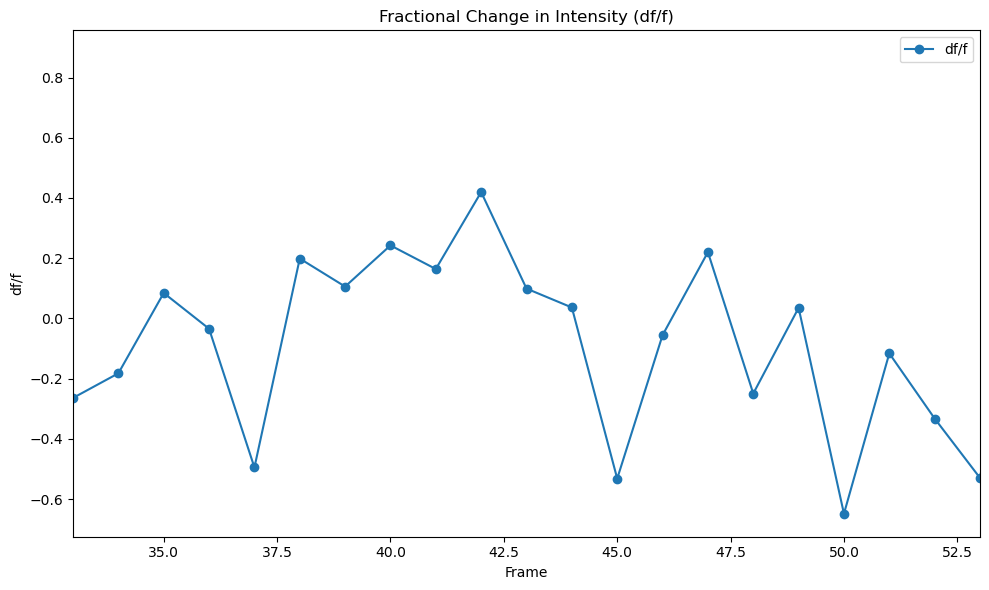

In [11]:
# Step 1: Read the CSV file
csv_path = f"{data_folder}/track_intensity_values.csv"
df = pd.read_csv(csv_path)

# Step 2: Extract the 'Mean' and 'Frame' columns
mean_values = df['Mean']
frame_values = df['Frame']

# Step 3: Calculate baseline (for example, mean of the first few frames)
# baseline = mean_values.iloc[:5].mean()  # Taking the first 5 frames as baseline (adjust as needed)
baseline = np.mean(mean_values)

# Step 4: Calculate df/f (fractional change in intensity)
df_f = 100*(mean_values - baseline) / baseline

# Step 5: Plot df/f vs Frame
plt.figure(figsize=(10, 6))
plt.plot(frame_values, df_f, '-o', label='df/f')
plt.xlim([33,53])
plt.xlabel('Frame')
plt.ylabel('df/f')
plt.title('Fractional Change in Intensity (df/f)')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Save the result back into the dataframe if needed
# df['df/f'] = df_f
# # Save the dataframe with df/f as a new CSV (optional)
# df.to_csv(f"{folder_path}/track_intensity_with_df_f.csv", index=False)


In [ ]:
# # 1. Calculate Instantaneous Shifts (x, y, and frame)
# tp_trajectories_filtered['x_shift'] = (tp_trajectories_filtered.groupby('particle')['x'].diff().fillna(0)) 
# tp_trajectories_filtered['y_shift'] = (tp_trajectories_filtered.groupby('particle')['y'].diff().fillna(0)) 
# tp_trajectories_filtered['frame_shift']  = tp_trajectories_filtered.groupby('particle')['frame'].diff().fillna(1)

# # 2. Calculate instantaneous displacement and velocity
# tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)
# tp_trajectories_filtered['inst_velocity'] = (tp_trajectories_filtered['displacement'] /
#                                              tp_trajectories_filtered['frame_shift'])

# # Drop NaN values from displacement and velocity
# tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'], inplace=True)



In [ ]:
# tp_trajectories_filtered

In [ ]:
# # 3. Calculate track-level metrics


# track_properties = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index()
# track_properties['track_length'] = track_properties['displacement'] / resolution

# # Dropping the 'displacement' column, if you only need 'track_length' in the resulting DataFrame
# track_properties = track_properties.drop(columns='displacement')

# # Calculate track_duration by finding the unique frames per particle
# track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')

# # Multiply by the frame interval to get the actual track duration in time
# track_duration['track_duration'] = (track_duration['track_duration']-1) * frame_interval

# # Merge the track_duration back into track_properties DataFrame
# track_properties = track_properties.merge(track_duration[['particle', 'track_duration']], on='particle', how='left')


# track_metrics = tp_trajectories_filtered.groupby('particle').agg(
#     x_start=('x', 'first'),
#     y_start=('y', 'first'),
#     x_end=('x', 'last'),
#     y_end=('y', 'last'),
#     frame_start=('frame', 'first'),
#     frame_end=('frame', 'last')
# ).reset_index()

# # Step 2: Calculate the distance traveled and the average velocity
# track_properties['distance'] = np.sqrt((track_metrics['x_end'] - track_metrics['x_start'])**2 +
#                                         (track_metrics['y_end'] - track_metrics['y_start'])**2) / resolution

# # Assuming 'track_duration' is already available from previous calculations
# track_properties['avg_velocity'] = track_properties['distance'] * 60 / track_properties['track_duration']

# # Calculate the instantaneous velocity (distance per frame)
# track_properties['inst_velocity'] =  track_properties['track_length'] * 60 / track_properties['track_duration']

# track_properties['sinuosity'] = track_properties['track_length'] / track_properties['distance']

# # Now track_metrics contains 'distance', 'avg_velocity', 'avg_inst_velocity', and 'sinuosity'
# # print(track_properties)
# print("Track properties calculated and stored in `track_propertiess` DataFrame")


In [ ]:
# plt.hist(1/track_properties['sinuosity'])

In [ ]:
# track_properties

In [12]:
def calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval):
    """
    Calculate and store instantaneous shifts, displacements, velocities, total track properties, 
    and other metrics for each particle's trajectory.

    Parameters:
    - tp_trajectories_filtered (pandas DataFrame): Particle tracking data with 'x', 'y', 'frame', and 'particle' columns.
    - resolution (float): Spatial resolution to convert units as required (e.g., pixels to microns).
    - frame_interval (float): Time interval between frames to calculate velocities and track duration.

    Returns:
    - tp_trajectories_filtered (pandas DataFrame): Input DataFrame with added columns:
        - 'x_shift': x-direction shift per frame for each particle.
        - 'y_shift': y-direction shift per frame for each particle.
        - 'frame_shift': Number of frames between positions in the trajectory.
        - 'displacement': Frame-to-frame displacement (Euclidean distance) in pixels.
        - 'inst_velocity': Instantaneous velocity per frame (#px./frame) for each particle.
    - track_properties (pandas DataFrame): Aggregated track-level metrics per particle, including:
        - 'track_length': Total track length, i.e., cumulative distance traveled by each particle (microns).
        - 'track_duration': Total duration of each particle's trajectory (seconds).
        - 'distance': Net displacement from initial to final position (microns).
        - 'avg_velocity': Average net velocity (net displacement divided by total time, in microns/min).
        - 'inst_velocity': Average instantaneous velocity (total track length divided by total time, in microns/min).
        - 'sinuosity': Measure of track straightness (track length divided by net displacement).
    """

    # Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = (tp_trajectories_filtered.groupby('particle')['x'].diff().fillna(0)) 
    tp_trajectories_filtered['y_shift'] = (tp_trajectories_filtered.groupby('particle')['y'].diff().fillna(0)) 
    tp_trajectories_filtered['frame_shift']  = tp_trajectories_filtered.groupby('particle')['frame'].diff().fillna(1)
    
    # Calculate instantaneous displacement and velocity
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)
    tp_trajectories_filtered['inst_velocity'] = (tp_trajectories_filtered['displacement'] /
                                                 tp_trajectories_filtered['frame_shift'])
    
    # Drop NaN values from displacement and velocity
    tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'], inplace=True)


    # Calculate track-level metrics: total distance traveled (track length), track duration, distance, average velocity, and sinuosity   
    
    # Calculate track length (total distance traversed) by summing displacements for each particle
    track_properties = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index()   
    track_properties['track_length'] = track_properties['displacement'] / resolution
    
    # Dropping the 'displacement' column from the new dataframe
    track_properties = track_properties.drop(columns='displacement')
    
    # Calculate track duration (total frames converted to seconds)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')
    track_duration['track_duration'] = (track_duration['track_duration']-1) * frame_interval
    
    # Merge the track_duration back into track_properties DataFrame
    track_properties = track_properties.merge(track_duration[['particle', 'track_duration']], on='particle', how='left')

    # Calculate total displacement (net distance between start and end positions)
    track_metrics = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last'),
        frame_start=('frame', 'first'),
        frame_end=('frame', 'last')
    ).reset_index()
    
    # Calculate total displacement (net distance between start and end positions)
    track_properties['distance'] = np.sqrt((track_metrics['x_end'] - track_metrics['x_start'])**2 +
                                            (track_metrics['y_end'] - track_metrics['y_start'])**2) / resolution
    
    # Calculate average net speed (net displacement / total time)
    track_properties['avg_velocity'] = track_properties['distance'] * 60 / track_properties['track_duration']
    
    # Calculate the average instantaneous velocity (track length / total time)
    track_properties['inst_velocity'] =  track_properties['track_length'] * 60 / track_properties['track_duration']

    # Calculate sinuosity (track length / net displacement)
    track_properties['sinuosity'] = track_properties['track_length'] / track_properties['distance']
    
    # Now track_metrics contains 'distance', 'avg_velocity', 'avg_inst_velocity', and 'sinuosity'


    return tp_trajectories_filtered, track_properties
    print("Trajectories and track properties calculated and stored.")

In [13]:
trajectories, metrics = calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval)

In [14]:
trajectories

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
frame,,,,,,,,,,,,,,,
0,279.876190,341.695238,12.130204,1.276155,0.101782,1.886921,64.872733,0.000942,0,18,0.000000,0.000000,1.0,0.000000,0.000000
1,280.644342,340.383372,6.313828,1.186919,0.520401,1.195690,27.383132,0.000976,1,18,-1.311866,0.768151,1.0,1.520214,1.520214
2,280.310458,341.643791,2.959529,1.255055,0.285403,0.473912,15.337748,0.001200,2,18,1.260419,-0.333884,1.0,1.303892,1.303892
2,173.983491,123.570755,4.100786,1.156401,0.281891,0.764061,23.878052,0.000771,2,116,0.000000,0.000000,1.0,0.000000,0.000000
3,280.126789,341.940695,4.642127,1.225997,0.079051,0.797421,23.857128,0.000735,3,18,0.296904,-0.183668,1.0,0.349122,0.349122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,200.673469,291.225417,56.795854,1.183138,0.207067,10.115774,271.224120,0.000545,148,3666,0.137804,0.368333,1.0,0.393268,0.393268
148,86.888889,54.663399,16.122014,1.104063,0.342333,3.161179,74.485835,0.001984,148,3867,3.406820,-0.404971,1.0,3.430805,3.430805
148,167.893645,414.192607,81.242307,1.196894,0.139176,13.435012,402.720088,0.000367,148,3877,-0.057088,-0.231508,2.0,0.238443,0.119221


In [15]:
metrics

,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,18,7.811891,50.03425,0.317139,0.380306,9.367853,24.632386
1,116,1.251439,18.01233,0.220932,0.735935,4.168609,5.664370
2,132,5.839743,14.00959,0.310246,1.328715,25.010338,18.822954
3,221,9.980221,28.01918,1.645486,3.523628,21.371549,6.065211
4,277,6.720853,16.01096,1.804994,6.764096,25.185945,3.723476
...,...,...,...,...,...,...,...
83,3708,5.933960,14.00959,0.353377,1.513436,25.413847,16.792155
84,3742,1.300420,14.00959,0.067305,0.288252,5.569415,19.321351
85,3830,6.514650,16.01096,1.455757,5.455353,24.413213,4.475093
86,3867,4.555964,16.01096,0.179059,0.671010,17.073172,25.443985
